# Notebook for Developing Experiments on CovType Data Set

In [142]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pickle
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier


from test_harness.datasets.dataset import Dataset
from test_harness.utils.utils import plot_experiment_error, plot_multiple_experiments, aggregate_experiment_metrics, plot_response_distributions_bysplit
from test_harness.experiments.baseline_experiment import BaselineExperiment
from test_harness.experiments.topline_experiment import ToplineExperiment
from test_harness.experiments.sqsi_experiment import SQSI_MRExperiment

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [2]:
with open("../data/covtype_induced_drift_forward.pkl", "rb") as f:
    drift_df, change_points = pickle.load(f)

In [3]:
drift_df

,elevation,aspect,slope,horizontal_dist_to_hydrology,vertical_dist_to_hydrology,horizontal_dist_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_dist_to_fire_points,wilderness_area_1,wilderness_area_2,wilderness_area_3,wilderness_area_4,cover_type
0,2836,343,15,190,3,700,188,216,166,1181,0,0,1,0,1
1,2939,174,14,182,27,4590,227,246,148,2665,1,0,0,0,1
2,3181,46,28,582,15,812,216,168,71,1681,0,1,0,0,0
3,3233,123,12,661,29,3030,240,231,120,3024,0,0,1,0,1
4,3023,24,8,531,43,1207,216,222,143,2347,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495136,150,187,33,2963,194,470,241,9,280,2683,1,0,0,0,1
495137,120,201,19,3049,186,871,251,16,244,3129,1,0,0,0,1
495138,283,151,58,3140,208,446,222,9,4,5030,0,1,0,0,1
495139,30,110,3,2939,238,2656,220,12,88,3625,0,1,0,0,1


## Experiments

### Prepare Test Harness

In [4]:
# specify columns and if categorical
col_names = [
    ("elevation", False),
    ("aspect", False),
    ("slope", False),
    ("horizontal_dist_to_hydrology", False),
    ("vertical_dist_to_hydrology", False),
    ("horizontal_dist_to_roadways", False),
    ("hillshade_9am", False),
    ("hillshade_noon", False),
    ("hillshade_3pm", False),
    ("horizontal_dist_to_fire_points", False),
]
wilderness_area_cols = [(f"wilderness_area_{i+1}", True) for i in range(4)]
col_names = col_names + wilderness_area_cols + [("cover_type", True)]

In [5]:
column_mapping = {
    "target": "cover_type",
    "numerical_features": [col for col, iscat in col_names if not iscat],
    "categorical_features": [col for col, iscat in col_names if iscat][:-1],
}

#17500
ED_dataset = Dataset(full_df=drift_df, column_mapping=column_mapping, window_size=17500*2)

model = RandomForestClassifier(n_estimators=5, random_state=42, max_depth=5)
param_grid = {"clf__n_estimators": [3, 5], "clf__max_depth": [3, 5]}

In [6]:
17500*3

52500

### Run

In [152]:
%%time

# baseline = BaselineExperiment(model=model, dataset=ED_dataset, param_grid=param_grid)
# baseline.run()

# topline = ToplineExperiment(model=model, dataset=ED_dataset, param_grid=param_grid)
# topline.run()

sqsi_mr = SQSI_MRExperiment(model=model, dataset=ED_dataset, param_grid=param_grid,  k=10, significance_thresh=0.001)
sqsi_mr.run()

Dataset Split: 1
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.06082224396406262, 0.9553130970093671), mean=0.5716289170237232, variance=0.04525515353122736, skewness=-0.25525888209036446, kurtosis=-1.4490534568632096)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.05469761266328168, 0.9364889657412903), mean=0.5724336764527335, variance=0.04413496540898556, skewness=-0.2361923104737391, kurtosis=-1.3692208632916418)
KS Test Result: FAILED | KstestResult(statistic=0.039085714285714335, pvalue=1.1500322764772724e-23)

Dataset Split: 2
REFERENCE STATS: DescribeResult(nobs=35000, minmax=(0.0816121163559665, 0.9527778656011489), mean=0.5692619706470071, variance=0.04405457077220757, skewness=-0.27349713949162585, kurtosis=-1.3962229871496274)
DETECTION STATS: DescribeResult(nobs=35000, minmax=(0.10851720863658243, 0.9126180190095148), mean=0.5705847543742076, variance=0.037197998686430006, skewness=-0.2184749594340605, kurtosis=-1.4491157455234216)
KS Test Result: FAILED | K

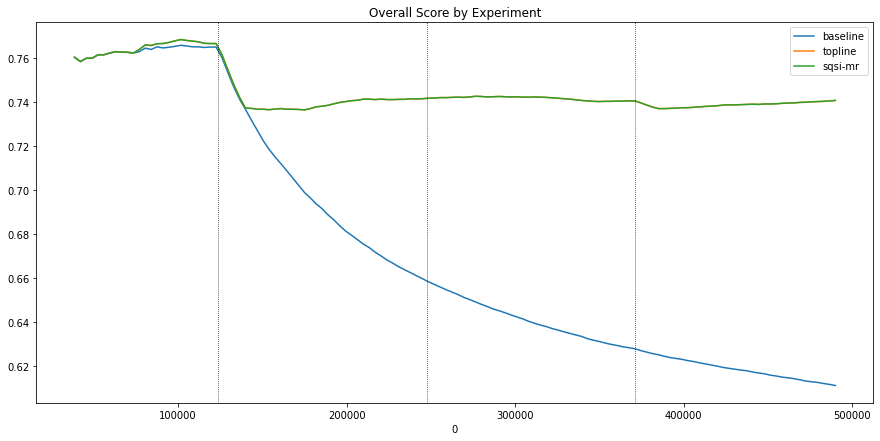

,times_retrained,percent_total_labels,total_train_time
experiment,,,
baseline,1,0.0707,0.12
topline,14,0.9896,1.38
sqsi-mr,14,0.9896,1.37


In [10]:
exps = [baseline, topline, sqsi_mr]
plot_multiple_experiments(exps, change_points)
aggregate_experiment_metrics(exps)

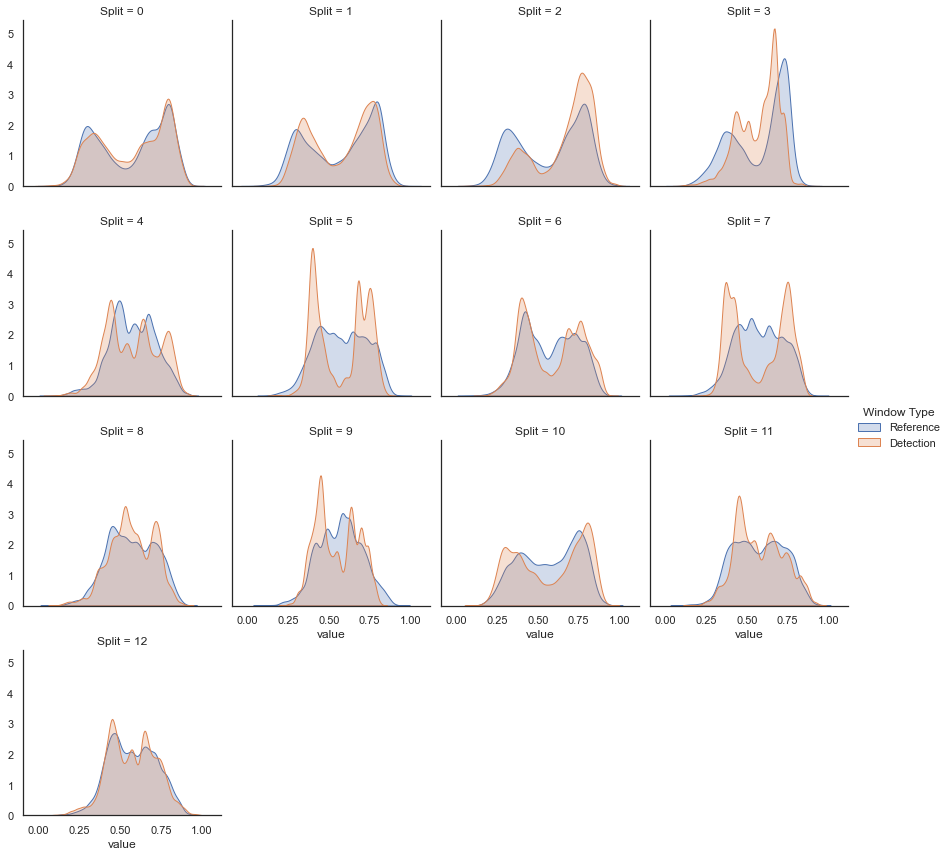

In [151]:
# @ k = 5
plot_response_distributions_bysplit(sqsi_mr)